# Symulacje modeli kwantowego uczenia maszynowego z wykorzystaniem Qiskit

## Podstawy

Pierwsza symulacja przedstawia prosty obwód kwantowy, na którym zliczane są wystąpienia poszczególnych stanów Bella.

Import bibliotek

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

Stworzenie obwodu

In [ ]:
circ = QuantumCircuit(2)
circ.h(0)
circ.cx(0, 1)
circ.measure_all()

simulator = AerSimulator()
circ = transpile(circ, simulator)
print(circ)

        ┌───┐      ░ ┌─┐   
   q_0: ┤ H ├──■───░─┤M├───
        └───┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░──╫─┤M├
             └───┘ ░  ║ └╥┘
meas: 2/══════════════╩══╩═
                      0  1 


Symulacja i wyniki

{'00': 510, '11': 514}


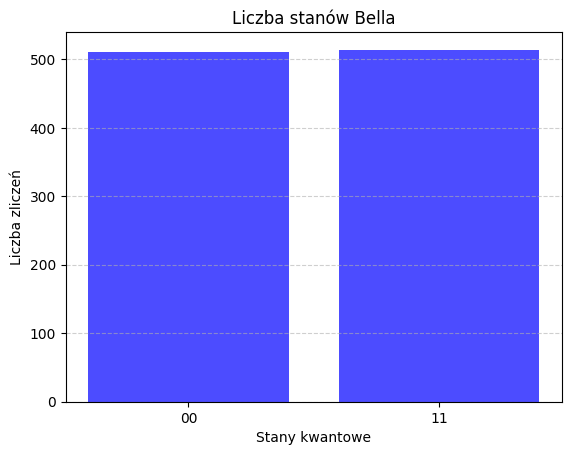

In [ ]:
result = simulator.run(circ).result()
counts = result.get_counts(circ)
print(counts)
labels = list(counts.keys())
values = list(counts.values())

plt.bar(labels, values, color='blue', alpha=0.7)
plt.title('Liczba stanów Bella')
plt.xlabel('Stany kwantowe')
plt.ylabel('Liczba zliczeń')
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

### WNIOSKI
Wyniki symulacji pokazują, że stany kwantowe |00⟩ i |11⟩ występują z bardzo zbliżoną częstotliwością (odpowiednio 510 i 514 zliczeń), co oznacza, że obwód kwantowy skutecznie wytworzył splątany stan Bella. Jednak wynik symulacji nie jest idealnie równy - może to wynikać z losowości symulatora kwantowego lub ograniczeń precyzji numerycznej. Mimo tego różnica między licznością stanów |00⟩ i |11⟩ jest bardzo niewielka, co wskazuje na wysoką dokładność symulatora. Użycie bramki Hadamarda (H) na pierwszym kubicie, a następnie bramki kontrolowanej NOT (CX), skutecznie przygotowuje splątanie.


## Prosty klasyfikator
Symulacja pokazująca klasyfikację na wygenerowanym zbiorze danych. Dane posiadają dwie cechy i są podzielone na dwie klasy. Dodatkowo porównanie z klasyfikatorem SVM.

Importy bibliotek

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_machine_learning.optimizers import COBYLA
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_machine_learning.utils import algorithm_globals

Przygotowanie danych

In [ ]:
algorithm_globals.random_seed = 8328
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, random_state=algorithm_globals.random_seed)
X = MinMaxScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=algorithm_globals.random_seed)

Wizualizacja zbioru danych (rozmieszczenie punktów klas w przestrzeni dwuwymiarowej)

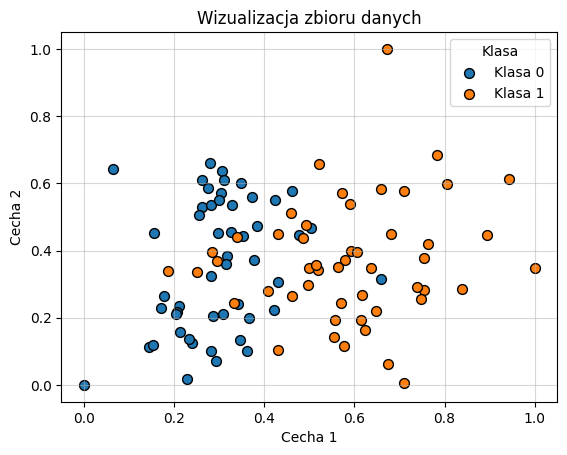

In [ ]:
labels = {0: 'Klasa 0', 1: 'Klasa 1'}
for class_value in [0, 1]:
    plt.scatter(X[y == class_value, 0], X[y == class_value, 1],
                label=labels[class_value], edgecolor='k', s=50)

plt.title("Wizualizacja zbioru danych")
plt.xlabel("Cecha 1")
plt.ylabel("Cecha 2")
plt.legend(title="Klasa")
plt.grid(alpha=0.5)
plt.show()

Klasyfikator klasyczny - SVM

In [ ]:
svm = SVC(kernel='linear', random_state=algorithm_globals.random_seed)
svm.fit(X_train, y_train)
svm_predictions = svm.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print(f"Klasyczny SVM - Dokładność: {svm_accuracy:.2f}")

Klasyczny SVM - Dokładność: 0.85


VQC - Klasyfikator kwantowy

In [ ]:
sampler = Sampler()
objective_func_vals = []

def callback_graph(weights, obj_func_eval):
    objective_func_vals.append(obj_func_eval)

vqc = VQC(
    num_qubits=2,
    optimizer=COBYLA(maxiter=100),
    callback=callback_graph,
    sampler=sampler,
)


vqc.fit(X_train, y_train)
vqc_predictions = vqc.predict(X_test)
vqc_accuracy = accuracy_score(y_test, vqc_predictions)
print(f"Kwantowy VQC - Dokładność: {vqc_accuracy:.2f}")

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


Kwantowy VQC - Dokładność: 0.70


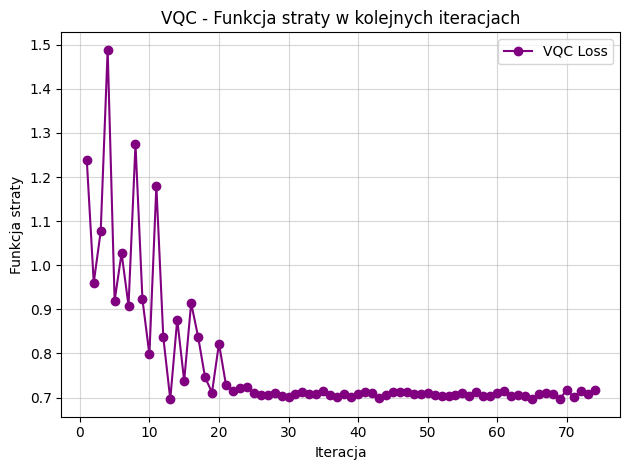

In [ ]:
plt.plot(range(1, len(objective_func_vals) + 1), objective_func_vals, marker='o', color='purple', label='VQC Loss')
plt.title("VQC - Funkcja straty w kolejnych iteracjach")
plt.xlabel("Iteracja")
plt.ylabel("Funkcja straty")
plt.grid(alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()

### WNIOSKI
Klasyczny klasyfikator SVM osiągnął dokładność 0.85, co oznacza, że w większości przypadków poprawnie sklasyfikował dane testowe.
Jest to oczekiwany wynik, biorąc pod uwagę dobrą separowalność danych i liniowy charakter SVM.

Klasyfikator kwantowy VQC osiągnął dokładność 0.70, co jest niższe niż wynik SVM. Może to wynikać z:
*   liczby iteracji (100 iteracji optymalizatora COBYLA),
*   prostej architektury obwodu kwantowego
*   ograniczeń w jakości odwzorowania danych w przestrzeni kwantowej przy wykorzystaniu tylko 2 kubitów.

Wykres funkcji straty pokazuje znaczne wahania wartości funkcji straty w początkowych iteracjach, co jest typowe dla optymalizatora COBYLA.
Po około 20 iteracjach funkcja straty stabilizuje się na poziomie około 0.7, co sugeruje, że proces uczenia osiągnął lokalne minimum.

Wyniki te mimo wszystko pokazują potencjał kwantowego modelu, zwłaszcza przy danych, które mogą wymagać bardziej złożonych, nieliniowych podziałów.
W eksperymencie kwantowy klasyfikator VQC osiągnął wynik niższy niż klasyczny SVM, co wskazuje na konieczność dalszego dopracowania modelu lub zastosowania lepszej symulacji. VQC ma potencjał, szczególnie w przypadkach bardziej skomplikowanych danych, których charakterystyki mogą być lepiej reprezentowane w przestrzeni kwantowej.

## Klasyfikator wieloklasowy
Symulacja na wielowymiarowym i wieloklasowym zbiorze danych - Digits. Dane zostaną ograniczone do 8 wymiarów.

Importy bibliotek

In [1]:
%matplotlib inline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_machine_learning.optimizers import COBYLA
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from qiskit_machine_learning.utils import algorithm_globals

Przygotowanie danych. Zastosowano redukcję wymiarów ze względu na zbyt długi czas symulacji klasyfikatora kwantowego.

In [2]:
algorithm_globals.random_seed = 42
digits = datasets.load_digits()
X = digits.data
y = digits.target
X = MinMaxScaler().fit_transform(X)

# REDUKCJA WYMIARÓW
pca = PCA(n_components=8)
X_reduced = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=algorithm_globals.random_seed)

Wizualizacja danych tylko dla dwóch pierwszych cech - niemożliwe jest pokazanie wykresu w 8 wymiarach.

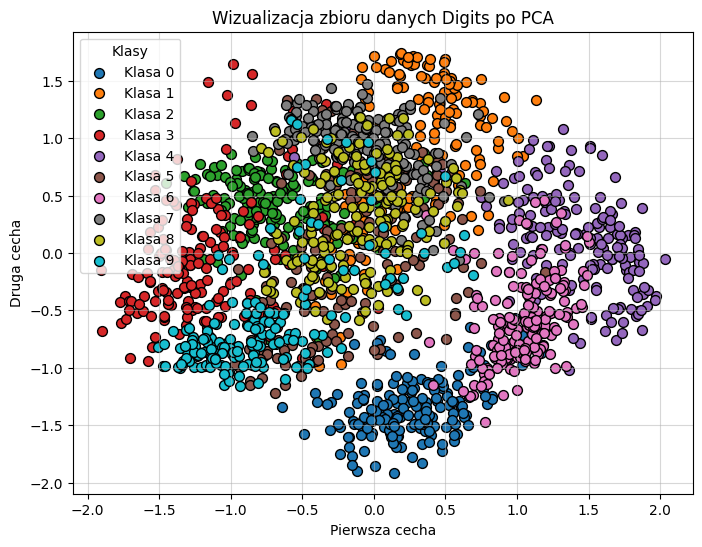

In [ ]:
plt.figure(figsize=(8, 6))
for class_value in np.unique(y):
    plt.scatter(X_reduced[y == class_value, 0], X_reduced[y == class_value, 1], label=f'Klasa {class_value}', edgecolor='k', s=50)
plt.title("Wizualizacja zbioru danych Digits po PCA")
plt.xlabel("Pierwsza cecha")
plt.ylabel("Druga cecha")
plt.legend(title="Klasy")
plt.grid(alpha=0.5)
plt.show()

Metoda klasyczna - SVM

In [ ]:
svm = SVC(kernel='linear', random_state=algorithm_globals.random_seed)
svm.fit(X_train, y_train)
svm_predictions = svm.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print(f"Klasyczny SVM - Dokładność: {svm_accuracy:.2f}")

Klasyczny SVM - Dokładność: 0.93


VQC - Klasyfikator kwantowy

In [3]:
optimizer = COBYLA(maxiter=20)
sampler = Sampler()
objective_func_vals = []
feature_map = ZZFeatureMap(feature_dimension=8, reps=2)
ansatz = RealAmplitudes(num_qubits=8, reps=2)

def callback_graph(weights, obj_func_eval):
    objective_func_vals.append(obj_func_eval)


vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    sampler=sampler,
    callback=callback_graph
)

vqc.fit(X_train, y_train)
vqc_predictions = vqc.predict(X_test)
vqc_accuracy = accuracy_score(y_test, vqc_predictions)
print(f"Kwantowy VQC - Dokładność: {vqc_accuracy:.2f}")

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


Kwantowy VQC - Dokładność: 0.09


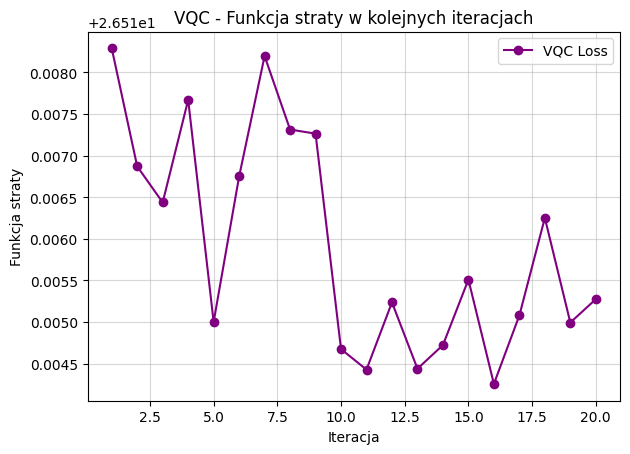

In [4]:
plt.plot(range(1, len(objective_func_vals) + 1), objective_func_vals, marker='o', color='purple', label='VQC Loss')
plt.title("VQC - Funkcja straty w kolejnych iteracjach")
plt.xlabel("Iteracja")
plt.ylabel("Funkcja straty")
plt.grid(alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()

### WNIOSKI
Model SVM osiągnął dokładność 0.93, co wskazuje na jego skuteczność przy klasyfikacji zbioru Digits.
Wynik ten dowodzi, że dla danych dobrze przygotowanych i zredukowanych do mniejszej liczby wymiarów klasyczny klasyfikator radzi sobie bardzo dobrze.

Model VQC osiągnął bardzo niską dokładność na poziomie 0.09.
Może być to spowodowane zbyt małą liczbą kubitów do odwzorowania całości zbioru jak i zbyt małą liczbą iteracji.
Optymalizator COBYLA został skonfigurowany na 20 iteracji, a czas ich przetwarzania wyniósł około 10 minut.

W porównaniu do klasycznego SVM, QML ma potencjał radzenia sobie z zadaniami, w których klasyczne algorytmy mogą być ograniczone ze względu na złożoność obliczeniową. Jednak wykorzystanie QML wymaga starannego przygotowania danych, optymalnej architektury obwodów kwantowych, a sama symulacja na komputerze klasycznym jest niezwykle wymagająca obliczeniowo.

Mimo to, QML wydaje się mieć potencjał w przypadku zastosowania na dedykowanym do tego komputerze kwantowym. W takim przypadku obliczenia zajęły by jedynie niewielki ułamek obecnego czasu przetwarzania i istniałaby możliwość zwiększenia liczby analizowanych kubitów, co mogłoby skutkować zwiększeniem skuteczności poprzez lepsze odzwierciedlenie problemu w modelu.